In [245]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras import Model
from keras.preprocessing import image
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

#### 10.1 Load Base Model and Add New Layers

In [300]:
#Load base model
base_model=MobileNet(weights='imagenet',include_top=False)

# Add new layers
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(3,activation='softmax')(x)

# Assign transfer base model + new layers to model
model=Model(inputs=base_model.input,outputs=preds)
model.summary()

# Assign Trainable layers and freeze layer -> ลองเปลี่ยน ช่วง layer ในการ trainable True/False 3 ค่า เพื่อดูความแตกต่างของผลลัพธ์ที่ได้
for layer in model.layers[:20]:
  layer.trainable=False
for layer in model.layers[20:]:
  layer.trainable=True

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                    

#### 10.2.1 Create ImageDataGenerator (Train, Validation)

In [301]:
# Create DataGeneartor Object
datagen=ImageDataGenerator( rescale=1./255, 
                            rotation_range=30, 
                            zoom_range=0.5,
                            width_shift_range=0.2, 
                            height_shift_range=0.2,
                            shear_range=0.15, 
                            horizontal_flip=True,
                            fill_mode="nearest"
                          )

# Create Train Image generator
train_generator=datagen.flow_from_directory('./dataset/Cat_Dog_Horse/train/', # this is where you specify the path to the main data folder
                                            target_size=(224,224), 
                                            color_mode='rgb',
                                            batch_size=32,
                                            class_mode='categorical', 
                                            seed = 1,
                                            shuffle=True
                                            )

# Create Validation Image generator
val_generator=datagen.flow_from_directory('./dataset/Cat_Dog_Horse/validate/', # this is where you specify the path to the main data folder
                                          target_size=(224,224), 
                                          color_mode='rgb',
                                          batch_size=16,
                                          class_mode='categorical', 
                                          seed = 1,
                                          shuffle=True
                                          )
                



Found 175 images belonging to 3 classes.
Found 31 images belonging to 3 classes.


#### View Training Images and Validation Images

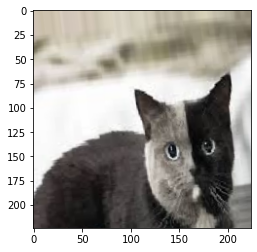

In [302]:
batch = train_generator.next()
# print(batch[0])
Img_train = (batch[0]*255).astype('uint8')
# Img_train = batch[0].astype('uint8')
plt.imshow(Img_train[0])
# print(batch[0]*255)
# Img_train[0]
# len(Img_train)

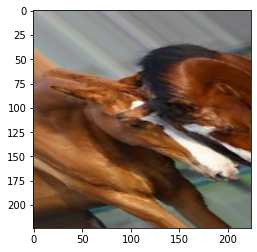

In [303]:
batch = val_generator.next()
Img_val = (batch[0]*255).astype('uint8')
# Img_val = batch[0].astype('uint8')
plt.imshow(Img_val[0])

#### 10.2.2 Create Optimizer, parameters

In [318]:
# Create Optimizer
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Define training Generator Parameter
EP = 32 # Number of Epoches
step_size_train=train_generator.n//train_generator.batch_size
step_size_val = val_generator.n//val_generator.batch_size
# check step_size_Train = step_size_val -> if not adjust batch_size to make it equal
history=model.fit_generator(generator=train_generator,
                            steps_per_epoch=step_size_train,
                            validation_data = val_generator,
                            validation_steps = step_size_val,
                            epochs=EP,
                            verbose=1
                            )

/var/folders/x0/4jvk1gmx0dx03m332jmgng5r0000gn/T/ipykernel_50957/3252193408.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator=train_generator,


Epoch 1/32
5/5 [==============================] - 11s 1s/step - loss: 0.3053 - accuracy: 0.9441 - val_loss: 1.1095 - val_accuracy: 0.8125
Epoch 2/32
5/5 [==============================] - 6s 1s/step - loss: 0.4333 - accuracy: 0.9091 - val_loss: 1.4785 - val_accuracy: 0.7500
Epoch 3/32
5/5 [==============================] - 5s 973ms/step - loss: 0.3304 - accuracy: 0.8601 - val_loss: 2.7502 - val_accuracy: 0.5625
Epoch 4/32
5/5 [==============================] - 5s 918ms/step - loss: 0.2956 - accuracy: 0.9441 - val_loss: 3.6047 - val_accuracy: 0.5000
Epoch 5/32
5/5 [==============================] - 7s 1s/step - loss: 0.1847 - accuracy: 0.9371 - val_loss: 3.4109 - val_accuracy: 0.5625
Epoch 6/32
5/5 [==============================] - 6s 1s/step - loss: 0.0950 - accuracy: 0.9650 - val_loss: 4.6672 - val_accuracy: 0.6250
Epoch 7/32
5/5 [==============================] - 6s 1s/step - loss: 0.1629 - accuracy: 0.9500 - val_loss: 5.1086 - val_accuracy: 0.5625
Epoch 8/32
5/5 [==================

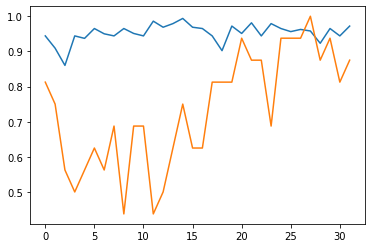

In [319]:
# Performance Visualization
# View Accuracy (Training, Validation)
plt.plot(history.history["accuracy"], label="Train_acc")
plt.plot(history.history["val_accuracy"], label="Validate_acc")

# View Loss (Training, Validation)
# plt.plot(history.history['loss'], label="Train_loss")
# plt.plot(history.history['val_loss'], label="Validate_loss")

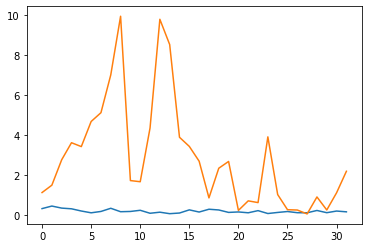

In [320]:
plt.plot(history.history['loss'], label="Train_loss")
plt.plot(history.history['val_loss'], label="Validate_loss")

#### 10.3.1 Create ImageDataGenerator (Test) and Predict Results

In [321]:
# Initial test generator
test_datagen= ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                                                  './dataset/Cat_Dog_Horse/test/',
                                                  class_mode="categorical",
                                                  target_size=(224, 224), 
                                                  color_mode="rgb",
                                                  shuffle=False, 
                                                  seed=1,
                                                  batch_size=1)

Found 16 images belonging to 3 classes.


In [322]:
#Get class id for y_real_class
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], dtype=int32)

In [323]:
#predict 1 image at a time for total predict images = len(y_true) # number of real class
test_generator.reset()
pred_prob = []
for i in range(len(y_true)):
  pred=model.predict_generator(test_generator.next()[0],verbose=0)
  pred_prob.append(np.array(pred[0]))

/var/folders/x0/4jvk1gmx0dx03m332jmgng5r0000gn/T/ipykernel_50957/3179890480.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=model.predict_generator(test_generator.next()[0],verbose=0)


In [324]:
pred_prob

[array([1.0000000e+00, 2.0527040e-08, 9.1404655e-15], dtype=float32),
 array([1.0000000e+00, 1.5286043e-14, 1.1017106e-20], dtype=float32),
 array([1.0000000e+00, 1.2976745e-16, 1.6335901e-22], dtype=float32),
 array([1.0000000e+00, 3.8870016e-10, 4.1787324e-15], dtype=float32),
 array([1.0000000e+00, 5.0502406e-12, 2.8456039e-17], dtype=float32),
 array([2.5810916e-02, 9.7402138e-01, 1.6768507e-04], dtype=float32),
 array([9.9978536e-01, 2.1450674e-04, 7.9640870e-08], dtype=float32),
 array([9.9999714e-01, 5.1246343e-07, 2.3348953e-06], dtype=float32),
 array([1.0000000e+00, 1.9287265e-12, 1.6379202e-15], dtype=float32),
 array([0.9524525 , 0.04044887, 0.00709876], dtype=float32),
 array([0.13524665, 0.8355897 , 0.02916365], dtype=float32),
 array([8.4307712e-01, 4.7404993e-07, 1.5692236e-01], dtype=float32),
 array([2.0632958e-02, 2.8837837e-08, 9.7936708e-01], dtype=float32),
 array([8.221774e-06, 4.530621e-09, 9.999918e-01], dtype=float32),
 array([4.5644283e-02, 2.0326529e-07, 9.5

In [325]:
# Get classID from max prob(pred_prob)
df_pred = pd.DataFrame(pred_prob)
df_class = df_pred.idxmax(axis=1)
# df_class => use dataframe -> idxmax(axis=1)
# Calculate confusion matrix, classification report between y_true and df_class



In [326]:
df_class

0     0
1     0
2     0
3     0
4     0
5     1
6     0
7     0
8     0
9     0
10    1
11    0
12    2
13    2
14    2
15    2
dtype: int64

In [327]:
confusion_matrix(y_true, df_class)

array([[5, 0, 0],
       [4, 2, 0],
       [1, 0, 4]])

In [329]:
print(classification_report(y_true, df_class))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67         5
           1       1.00      0.33      0.50         6
           2       1.00      0.80      0.89         5

    accuracy                           0.69        16
   macro avg       0.83      0.71      0.69        16
weighted avg       0.84      0.69      0.67        16

